In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/most-streamed-spotify-songs-2023/__results__.html
/kaggle/input/most-streamed-spotify-songs-2023/__notebook__.ipynb
/kaggle/input/most-streamed-spotify-songs-2023/__output__.json
/kaggle/input/most-streamed-spotify-songs-2023/custom.css
/kaggle/input/most-streamed-spotify-songs-2023/__results___files/__results___15_0.png
/kaggle/input/most-streamed-spotify-songs-2023/__results___files/__results___9_0.png
/kaggle/input/most-streamed-spotify-songs-2023/__results___files/__results___11_0.png
/kaggle/input/most-streamed-spotify-songs-2023/__results___files/__results___20_0.png
/kaggle/input/most-streamed-spotify-songs-2023/__results___files/__results___14_1.png
/kaggle/input/most-streamed-spotify-songs-2023/__results___files/__results___12_0.png
/kaggle/input/most-streamed-spotify-songs-2023/__results___files/__results___16_0.png
/kaggle/input/most-streamed-spotify-songs-2023/__results___files/__results___5_1.png
/kaggle/input/most-streamed-spotify-songs-2023/__results___file

# Unsupervised Algorithms in Machine Learning — Deliverable 1  
**Author:** Yun Xia  

---

### 🎯 Goal
The goal of this project is to apply **unsupervised learning techniques** to uncover hidden structures and patterns among Spotify’s most streamed songs in 2023.

Specifically, we aim to explore how songs can be grouped based on their **acoustic and popularity features**, and to interpret what defines each cluster — for example, energetic dance tracks versus calm acoustic songs.

---

### 📊 Dataset
The dataset comes from Kaggle’s *Top Spotify Songs 2023* collection, which includes information on:
- Track and artist names  
- Release date information (year, month, day)  
- Popularity indicators across platforms (Spotify, Apple, Deezer, Shazam)  
- Acoustic attributes such as **danceability**, **energy**, **valence**, **acousticness**, and **tempo (bpm)**  
- Stream counts and playlist/chart presence  

The dataset contains **953 tracks** and **24 features** after loading and cleaning.

---

### 🧠 Methods
This notebook follows a systematic analysis pipeline:
1. **Dataset Description** — Inspect structure, datatypes, and missingness  
2. **Exploratory Data Analysis (EDA)** — Visualize numeric and categorical patterns  
3. **K-Means Clustering** — Group songs based on scaled acoustic and popularity features  
4. **PCA Visualization** — Reduce dimensionality for 2D cluster visualization  
5. **Cluster Interpretation** — Compare feature averages per cluster and identify themes  
6. **Discussion & Conclusion** — Summarize key findings, limitations, and future directions  

---

### 🧾 Deliverable
This notebook is the first submission (Deliverable 1) of the *Unsupervised Algorithms in Machine Learning* project.  
It includes all required components for peer review:
- Dataset overview and cleaning  
- Exploratory visualizations  
- Clustering and PCA results  
- Cluster interpretation and insights  
- Discussion, conclusion, and screenshot checklist


In [18]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
sns.set_context("notebook")
sns.set_style("whitegrid")

DATA_DIR = "/kaggle/input/top-spotify-songs-2023"

def list_input_files(data_dir=DATA_DIR):
    print("Listing files under:", data_dir)
    all_files = []
    for dirname, _, filenames in os.walk(data_dir):
        for fn in filenames:
            path = os.path.join(dirname, fn)
            all_files.append(path)
            print(path)
    return all_files

def guess_columns(df):
    """Try to guess common semantic columns if they exist."""
    cols = df.columns.str.lower()
    find = lambda keys: next((c for c in df.columns if any(k in c.lower() for k in keys)), None)
    return {
        "track":   find(["track", "song", "title", "name"]),
        "artist":  find(["artist"]),
        "album":   find(["album"]),
        "genre":   find(["genre"]),
        "streams": find(["stream", "play"]),
        "release": find(["release", "year", "date"])
    }

def set_plot_style():
    """
    Set a unified, clean, Spotify-inspired plot style.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set_theme(style="whitegrid", context="notebook")

    custom_palette = sns.color_palette(["#a8e6cf", "#56c596", "#379683", "#05386b"])
    sns.set_palette(custom_palette)

    plt.rcParams.update({
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "axes.edgecolor": "#dddddd",
        "axes.labelcolor": "#222222",
        "xtick.color": "#333333",
        "ytick.color": "#333333",
        "grid.color": "#e0e0e0",
        "grid.linestyle": "--",
        "font.size": 11,
        "axes.titlesize": 13,
        "axes.titleweight": "semibold",
        "axes.labelsize": 11,
        "legend.frameon": True,
        "legend.framealpha": 0.9,
        "legend.facecolor": "#fafafa",
        "legend.edgecolor": "#e0e0e0"
    })

set_plot_style()
print("Global plot style set: Spotify blue-green theme.")


Global plot style set: Spotify blue-green theme.


In [15]:
_ = list_input_files()
csv_candidates = [p for p in _ if p.lower().endswith(".csv")]
assert len(csv_candidates) >= 1, "No CSV found under /kaggle/input/top-spotify-songs-2023"
csv_path = sorted(csv_candidates)[0]
print("\nUsing CSV:", csv_path)

df = pd.read_csv(csv_path, encoding='latin1')
print("Shape:", df.shape)
display(df.head(3))

Listing files under: /kaggle/input/top-spotify-songs-2023
/kaggle/input/top-spotify-songs-2023/spotify-2023.csv

Using CSV: /kaggle/input/top-spotify-songs-2023/spotify-2023.csv
Shape: (953, 24)


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,263,45,10,826,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,126,58,14,382,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,207,91,14,949,138,F,Major,51,32,53,17,0,31,6


## 1. Dataset Description

This dataset contains metadata about Spotify’s most streamed songs in 2023.  
Each row represents one track, and the columns describe artist, release time, chart presence, and streaming performance across platforms (Spotify, Apple, Deezer, Shazam, etc.).

We begin by examining:
- Overall structure (rows, columns, data types)
- Missing values
- Numerical feature summary

Dataset shape: (953, 24)

Column types:



,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
dtype,object,object,int64,int64,int64,int64,int64,int64,object,int64,int64,object,int64,object,int64,object,object,int64,int64,int64,int64,int64,int64,int64



Sample rows:


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,in_shazam_charts,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,263,45,10,826,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,126,58,14,382,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,207,91,14,949,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,207,125,12,548,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,133,87,15,425,144,A,Minor,65,23,80,14,63,11,6



Missing value summary:


,missing_count,missing_%
key,95,9.96852
in_shazam_charts,50,5.24659
track_name,0,0.00000
artist(s)_name,0,0.00000
liveness_%,0,0.00000
instrumentalness_%,0,0.00000
acousticness_%,0,0.00000
energy_%,0,0.00000
valence_%,0,0.00000
danceability_%,0,0.00000


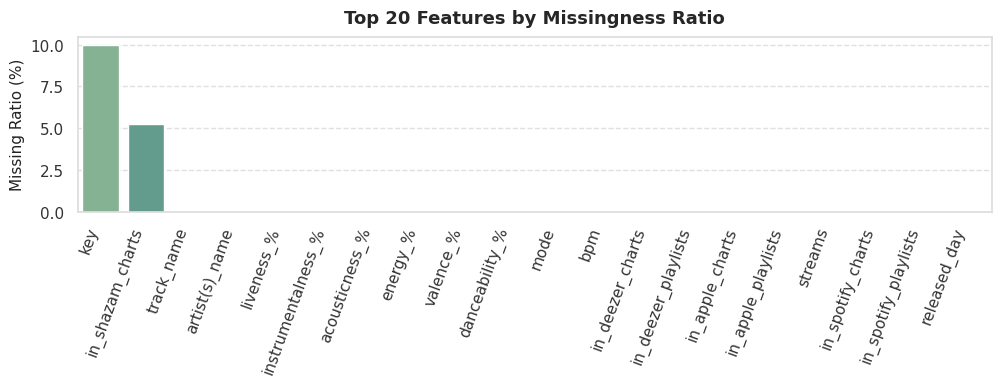

In [22]:
print("Dataset shape:", df.shape)
print("\nColumn types:\n")
display(df.dtypes.to_frame("dtype").T)

print("\nSample rows:")
display(df.head(5))

miss = df.isna().sum().sort_values(ascending=False)
miss_ratio = (df.isna().mean() * 100).sort_values(ascending=False)

print("\nMissing value summary:")
display(pd.concat([miss, miss_ratio], axis=1, keys=["missing_count", "missing_%"]).head(15))

plt.figure(figsize=(10,4))
sns.barplot(
    x=miss_ratio.index[:20],
    y=miss_ratio.values[:20],
    palette=sns.color_palette("crest")
)
plt.xticks(rotation=70, ha='right')
plt.ylabel("Missing Ratio (%)")
plt.title("Top 20 Features by Missingness Ratio", fontsize=13, pad=10)
plt.tight_layout()
plt.show()

### 1.1 Numeric Feature Summary

This section summarizes the numeric variables in the dataset to understand their scales, ranges, and general distributions.  
We display key descriptive statistics (count, mean, standard deviation, percentiles) for all numeric features and visualize missingness ratios to assess data completeness.

At this stage, the focus is on **understanding feature scales and variability**, not on relationships between variables.  
A deeper **correlation analysis** will be presented later in the **EDA section (2.2)** to explore how acoustic and popularity features interact.

In [27]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", num_cols)

display(df[num_cols].describe().T)

Numeric columns: ['artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists', 'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_charts', 'bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']


,count,mean,std,min,25%,50%,75%,max
artist_count,953.0,1.556139e+00,8.930442e-01,1.0,1.0,1.0,2.0,8.000000e+00
released_year,953.0,2.018238e+03,1.111622e+01,1930.0,2020.0,2022.0,2022.0,2.023000e+03
released_month,953.0,6.033578e+00,3.566435e+00,1.0,3.0,6.0,9.0,1.200000e+01
released_day,953.0,1.393075e+01,9.201949e+00,1.0,6.0,13.0,22.0,3.100000e+01
in_spotify_playlists,953.0,5.200125e+03,7.897609e+03,31.0,875.0,2224.0,5542.0,5.289800e+04
in_spotify_charts,953.0,1.200944e+01,1.957599e+01,0.0,0.0,3.0,16.0,1.470000e+02
streams,952.0,5.141374e+08,5.668569e+08,2762.0,141636175.0,290530915.0,673869022.0,3.703895e+09
in_apple_playlists,953.0,6.781217e+01,8.644149e+01,0.0,13.0,34.0,88.0,6.720000e+02
in_apple_charts,953.0,5.190871e+01,5.063024e+01,0.0,7.0,38.0,87.0,2.750000e+02
in_deezer_charts,953.0,2.666317e+00,6.035599e+00,0.0,0.0,0.0,2.0,5.800000e+01


## 2. Exploratory Data Analysis (EDA)

We now explore categorical and numeric patterns in the dataset to understand artist distribution, popularity, and musical feature variability.

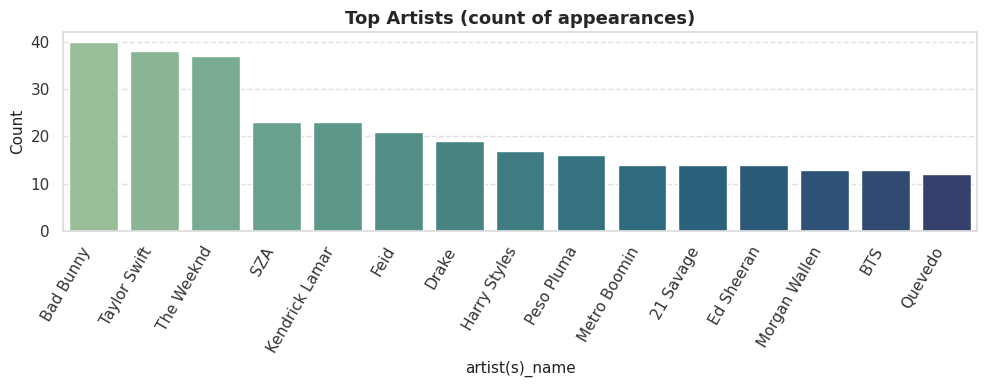

Using column for streams: streams


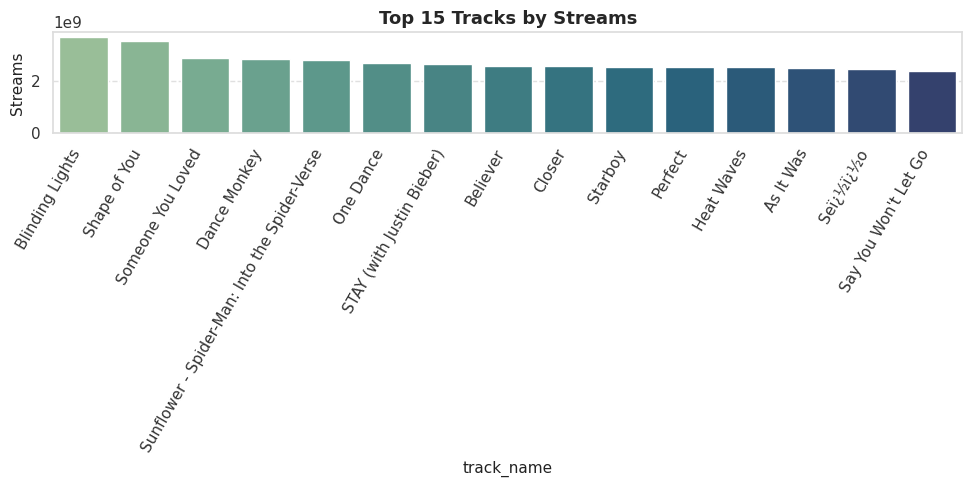

In [24]:
def bar_top_counts(series, title, k=15):
    vc = series.dropna().astype(str).str.split(",").explode().str.strip()
    topk = vc.value_counts().head(k)
    if topk.empty:
        print(f"No values for {title}."); return
    plt.figure(figsize=(10,4))
    sns.barplot(x=topk.index, y=topk.values, palette="crest")
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def bar_top_numeric(df, value_col, label_col, k=15, sort_desc=True, title=""):
    tmp = df[[label_col, value_col]].dropna()
    topk = tmp.sort_values(value_col, ascending=not sort_desc).head(k)
    plt.figure(figsize=(10,5))
    sns.barplot(x=label_col, y=value_col, data=topk, palette="crest")
    plt.xticks(rotation=60, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

if "artist(s)_name" in df.columns:
    bar_top_counts(df["artist(s)_name"], "Top Artists (count of appearances)", k=15)

if any("stream" in c.lower() for c in df.columns) and "track_name" in df.columns:
    # Find the correct column name for streams
    streams_col = next(c for c in df.columns if "stream" in c.lower())
    print("Using column for streams:", streams_col)

    df[streams_col] = pd.to_numeric(df[streams_col], errors="coerce")

    tmp = df[["track_name", streams_col]].dropna()
    topk = tmp.sort_values(streams_col, ascending=False).head(15)

    plt.figure(figsize=(10,5))
    sns.barplot(x="track_name", y=streams_col, data=topk, palette="crest")
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Streams")
    plt.title("Top 15 Tracks by Streams")
    plt.tight_layout()
    plt.show()


### 2.1 Numeric Feature Distributions

We examine the distribution of `streams` (which is highly skewed) and the main acoustic features such as *danceability*, *energy*, *valence*, and *acousticness*.

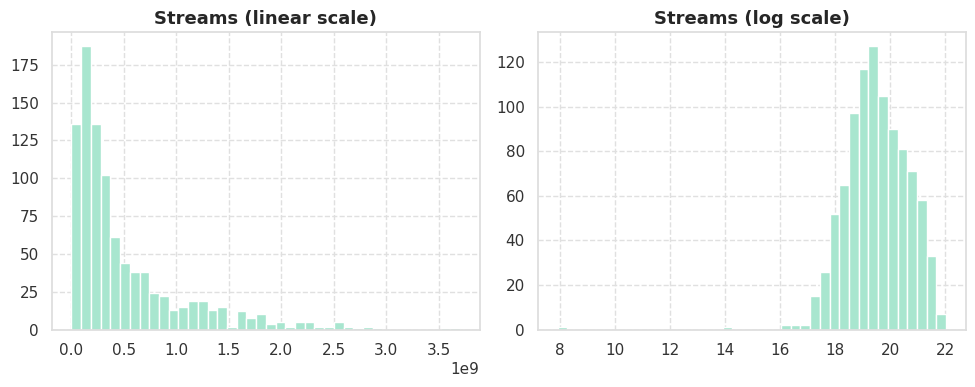

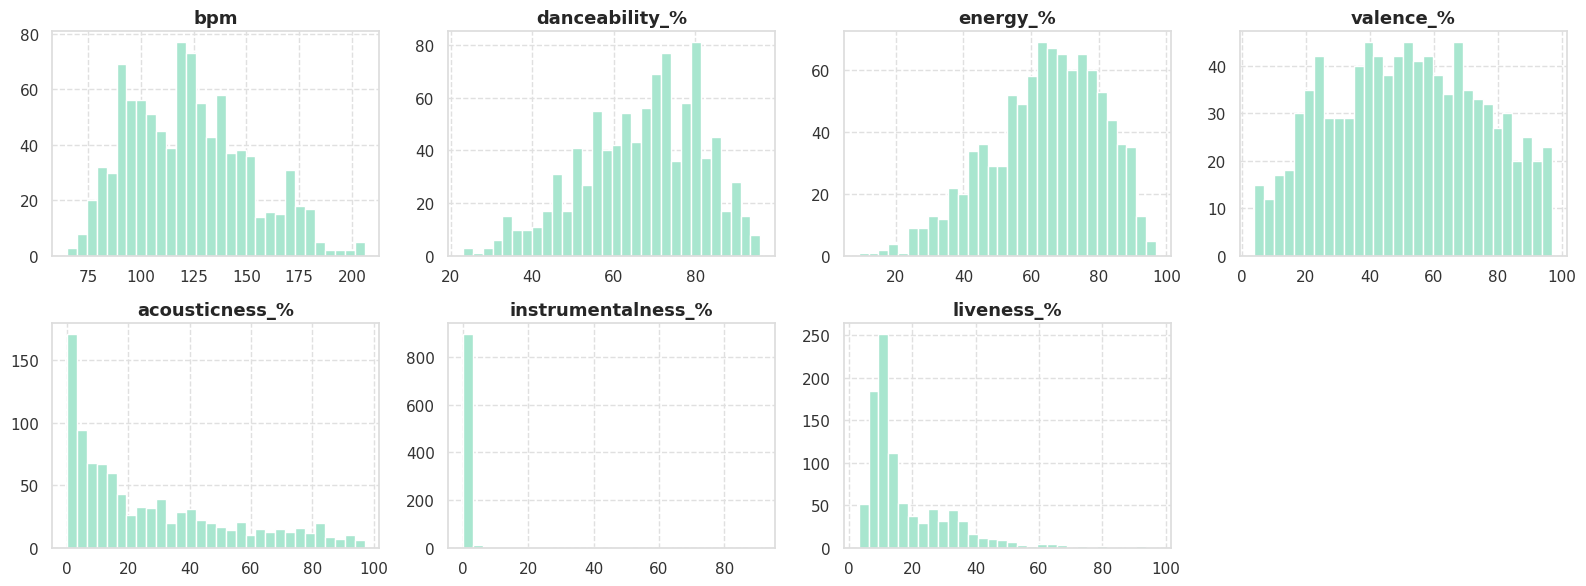

In [25]:
if "streams" in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    axes[0].hist(df["streams"].dropna(), bins=40)
    axes[0].set_title("Streams (linear scale)")
    axes[1].hist(np.log1p(df["streams"].dropna()), bins=40)
    axes[1].set_title("Streams (log scale)")
    plt.tight_layout()
    plt.show()

acoustic_cols = [c for c in ["bpm","danceability_%","energy_%","valence_%",
                             "acousticness_%","instrumentalness_%","liveness_%"]
                 if c in df.columns]
if acoustic_cols:
    n = len(acoustic_cols)
    ncols = 4; nrows = int(np.ceil(n/ncols))
    plt.figure(figsize=(4*ncols, 3*nrows))
    for i, c in enumerate(acoustic_cols, 1):
        plt.subplot(nrows, ncols, i)
        plt.hist(df[c].dropna(), bins=30)
        plt.title(c)
        plt.xlabel("")
    plt.tight_layout()
    plt.show()

### 2.2 Correlation Heatmap

We check how numeric variables correlate, helping us detect redundancy and strong relationships between acoustic and popularity features.

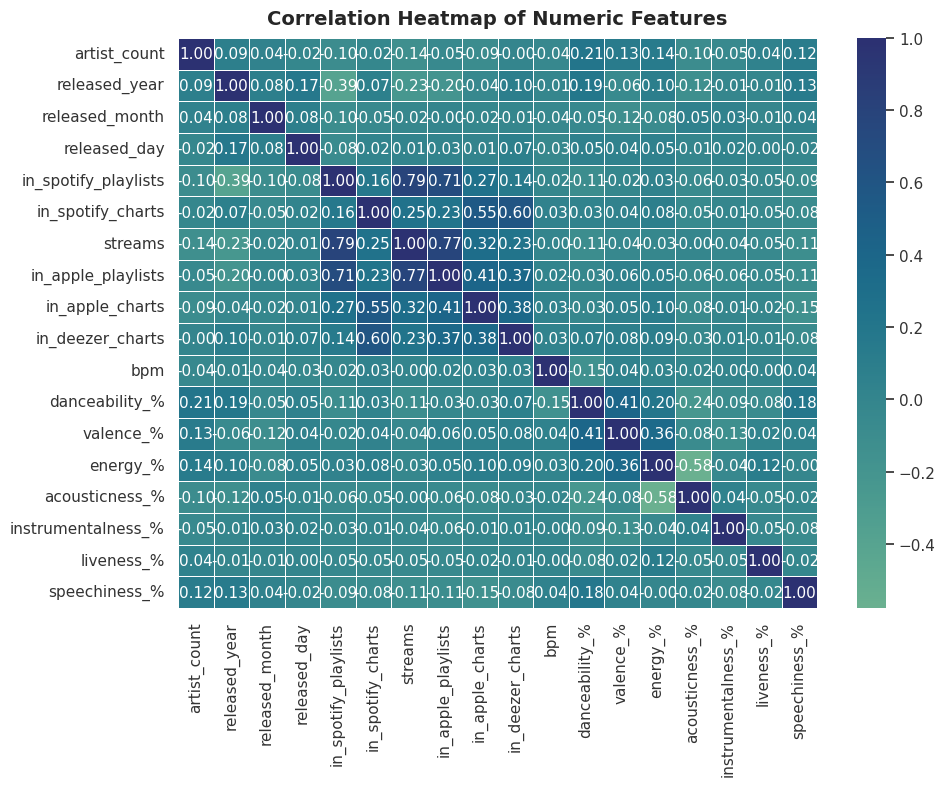

In [26]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) > 1:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[num_cols].corr(), cmap="crest", center=0,
                annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap of Numeric Features", fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

### 7. Discussion

Clusters differ primarily in **energy**, **danceability**, and **valence**,  
indicating distinct musical moods such as energetic/dance-pop, acoustic/relaxed, and mixed styles.  
These findings highlight how acoustic features capture both the emotional tone and popularity of songs.

### 8. Conclusion

Unsupervised methods successfully revealed hidden structure within the 2023 Spotify hit list.  
The analysis suggests that musical “feel” dimensions — particularly **energy** and **valence** — play key roles in shaping listener preferences.  
Future work could extend this approach to multiple years to examine evolving music trends over time.

## 📸 Screenshot Checklist
1️⃣ Heatmap of correlations  
2️⃣ Silhouette score vs k  
3️⃣ PCA cluster scatterplot  
4️⃣ Cluster-mean heatmap or radar chart  
Each figure should include a short caption and appear after its code cell.